<a href="https://www.kaggle.com/code/irfandahusnisahid/irf01-rfm-customer-segmentation?scriptVersionId=116503620" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## RFM Customer Segmentation
<br>by: <i>Irfanda Husni </i>

### 1. Background

As a business, we want to sustain our customer. In other words, we want to increase the number of our recurring customer. Sustaining recurring customer is cheaper than acquiring new customers, this because they already know our product/service. One way to perform this is by performing direct marketing (with promos) to our existing customers. 
<br><br>
Not all customers are worthy to be given these promos. We want to make sure that we give promos for the right customers. One of the ways to finding the right customer is by dividing our customers into some groups (also known as customer segmentation). 
<br>
<br>
Put it simply, there are 10 customer segmentations namely:
<ul>
    <li>Champions</li>
    <li>Potential Loyalists</li>
    <li>Promising</li>
    <li>New Customers</li>
    <li>Loyal Customers</li>
    <li>Can't Loose</li>
    <li>About to Sleep</li>
    <li>At Risk</li>
    <li>Hibernating</li>
    <li>Need Attention</li>
</ul>

Now we want to find these segments in our dataset. 
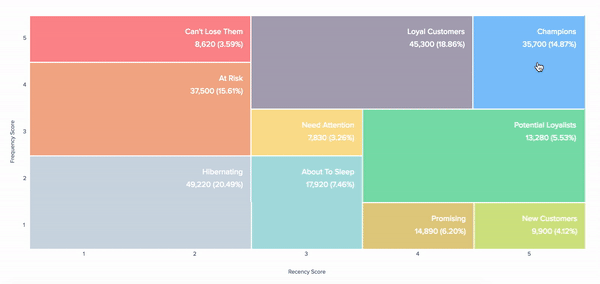

In [1]:
# Libraries
import datetime
import warnings
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.metrics import silhouette_samples, silhouette_score

sns.set_style("darkgrid")
warnings.filterwarnings('ignore')

### 2. Dataset

We will be using data from retail store sales from kaggle, you can find the dataset in [here](https://www.kaggle.com/datasets/marian447/retail-store-sales-transactions).

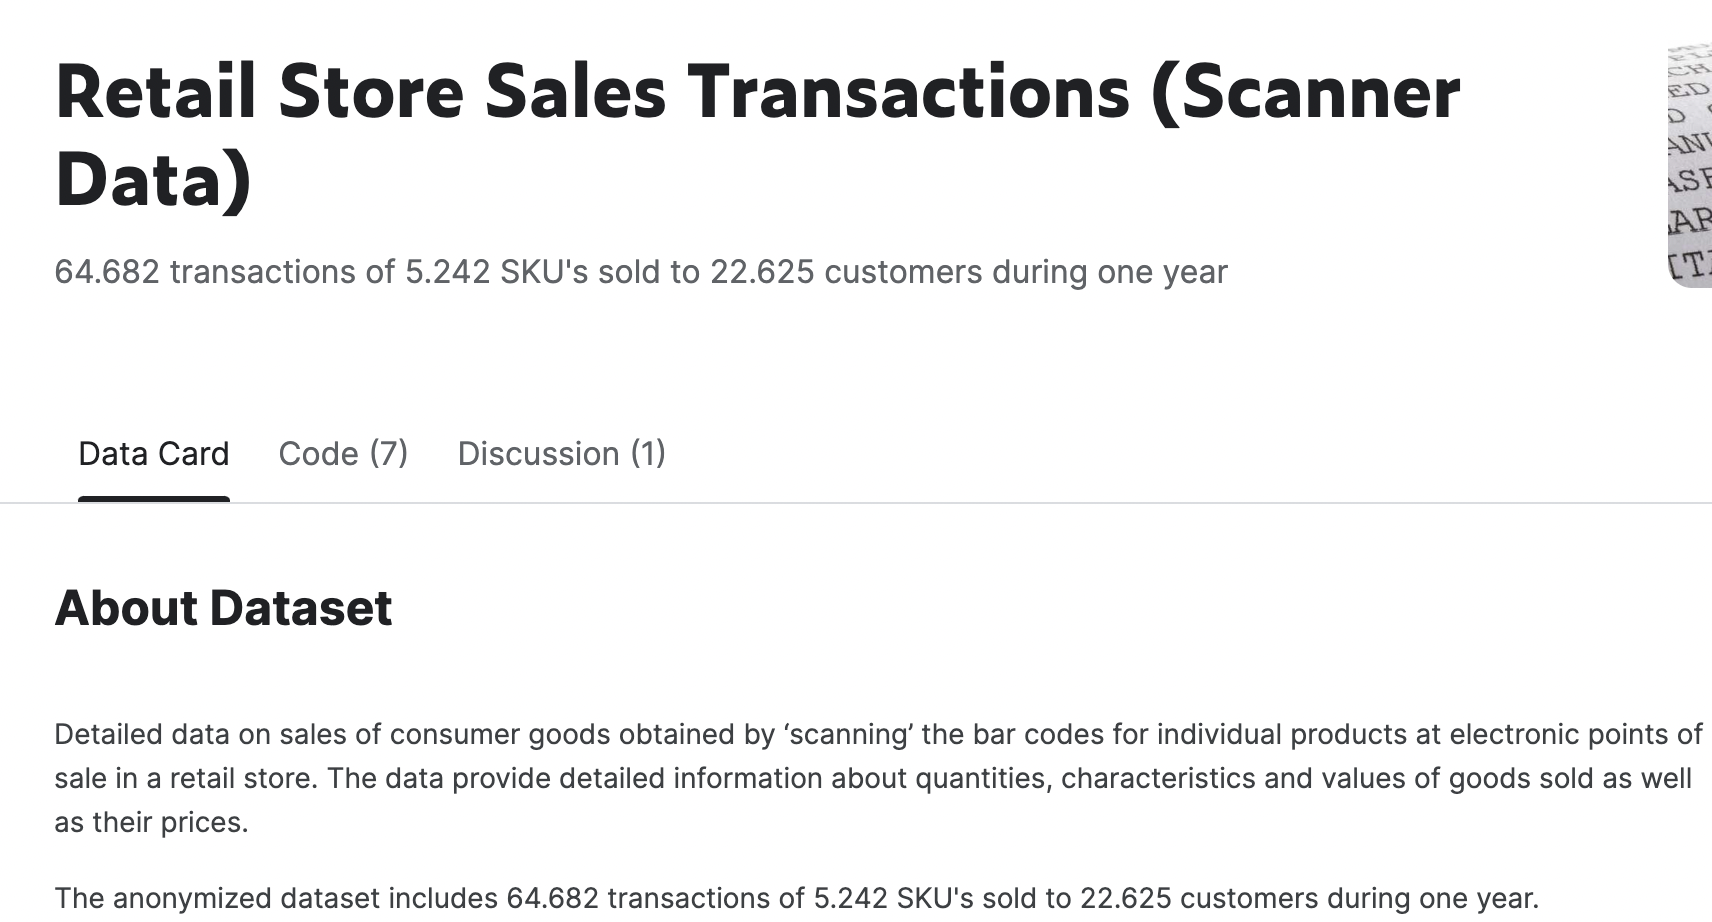

Let's preview our data.

In [2]:
#Dataset
data = pd.read_csv("../input/retail-store-sales-transactions/scanner_data.csv", index_col=0)
data.head()

,Date,Customer_ID,Transaction_ID,SKU_Category,SKU,Quantity,Sales_Amount
1,02/01/2016,2547,1,X52,0EM7L,1.0,3.13
2,02/01/2016,822,2,2ML,68BRQ,1.0,5.46
3,02/01/2016,3686,3,0H2,CZUZX,1.0,6.35
4,02/01/2016,3719,4,0H2,549KK,1.0,5.59
5,02/01/2016,9200,5,0H2,K8EHH,1.0,6.88


There are some columns type that need to be adjusted. I will fix the columns type by creating some new columns. 

In [3]:
#Preprocessing
data["transaction_date"] = pd.to_datetime(data["Date"], format='%d/%m/%Y',errors='ignore')
data["quantity_int"] = np.ceil(data["Quantity"]).astype("int")
data["Customer_ID"] = data["Customer_ID"].astype("str")
data = data.drop_duplicates()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 131706 entries, 1 to 131706
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Date              131706 non-null  object        
 1   Customer_ID       131706 non-null  object        
 2   Transaction_ID    131706 non-null  int64         
 3   SKU_Category      131706 non-null  object        
 4   SKU               131706 non-null  object        
 5   Quantity          131706 non-null  float64       
 6   Sales_Amount      131706 non-null  float64       
 7   transaction_date  131706 non-null  datetime64[ns]
 8   quantity_int      131706 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 10.0+ MB


In [4]:
data.head()

,Date,Customer_ID,Transaction_ID,SKU_Category,SKU,Quantity,Sales_Amount,transaction_date,quantity_int
1,02/01/2016,2547,1,X52,0EM7L,1.0,3.13,2016-01-02,1
2,02/01/2016,822,2,2ML,68BRQ,1.0,5.46,2016-01-02,1
3,02/01/2016,3686,3,0H2,CZUZX,1.0,6.35,2016-01-02,1
4,02/01/2016,3719,4,0H2,549KK,1.0,5.59,2016-01-02,1
5,02/01/2016,9200,5,0H2,K8EHH,1.0,6.88,2016-01-02,1


Let's preview some information from our data. 

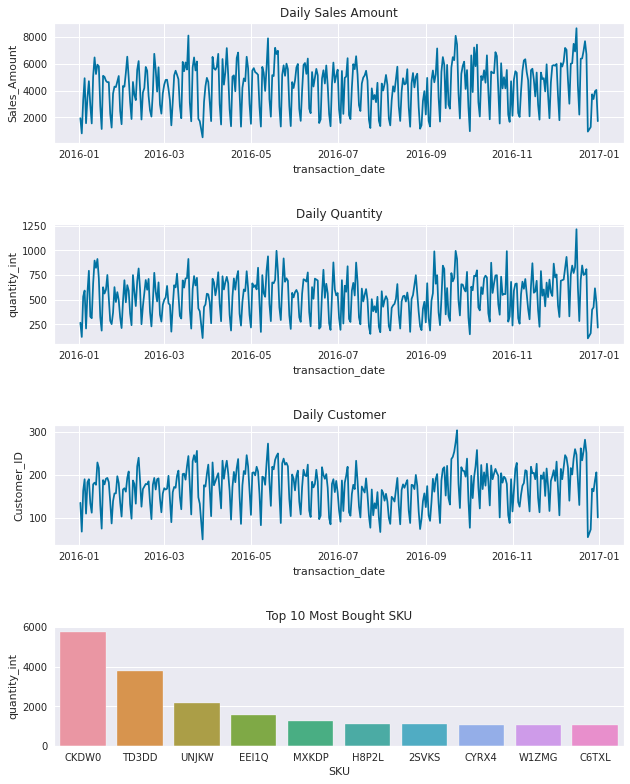

In [5]:
fig,ax = plt.subplots(4, 1, sharey=False, figsize=(10,12))
fig.tight_layout(pad=5.0)

ax[0].set_title("Daily Sales Amount")
agg_0 = data.groupby("transaction_date").sum()[["Sales_Amount"]]
sns.lineplot(x="transaction_date",y="Sales_Amount",data=agg_0,ax=ax[0])

ax[1].set_title("Daily Quantity")
agg_1 = data.groupby("transaction_date").sum()[["quantity_int"]]
sns.lineplot(x="transaction_date",y="quantity_int",data=agg_1,ax=ax[1])

ax[2].set_title("Daily Customer")
agg_2 = data[["transaction_date","Customer_ID"]].drop_duplicates().groupby(["transaction_date"]).count()[["Customer_ID"]].reset_index()
sns.lineplot(x="transaction_date",y="Customer_ID",data=agg_2,ax=ax[2])

ax[3].set_title("Top 10 Most Bought SKU")
agg_3 = data[["SKU","quantity_int"]].groupby("SKU").sum("quantity_int").sort_values(by="quantity_int",ascending=False).iloc[0:10].reset_index()
sns.barplot(x="SKU",y="quantity_int",data=agg_3,ax=ax[3])

plt.show()

From here we can see that sales is fluctuating over time. As in the last picture, we can see that SKU CKDW0 is the most bought SKU. 

### 3. Create RFM Features
I will create Recency, Frequency, and Monetary features. For recency, I will use todays date on 1 January 2017 because the last purchase date was on December 2016. 

In [6]:
recency = data[["Customer_ID","transaction_date"]].groupby("Customer_ID").max().reset_index()[["Customer_ID","transaction_date"]]
recency = recency.rename(columns = {"transaction_date":"last_purchase_date"})
# Latest purchase date is in December 2016
# We assume that today is 1 January 2017
recency["today"] = datetime.datetime(2017,1,1)
recency["recency"] = (recency['today'] - recency['last_purchase_date']) / np.timedelta64(1, 'D') 
recency.head()

,Customer_ID,last_purchase_date,today,recency
0,1,2016-01-22,2017-01-01,345.0
1,10,2016-02-12,2017-01-01,324.0
2,100,2016-01-03,2017-01-01,364.0
3,1000,2016-02-15,2017-01-01,321.0
4,10000,2016-05-17,2017-01-01,229.0


In [7]:
frequency = data[["Customer_ID","Transaction_ID"]].groupby("Customer_ID").count().reset_index()[["Customer_ID","Transaction_ID"]].rename(columns={"Transaction_ID":"frequency"})
frequency.head()                                                                                    

,Customer_ID,frequency
0,1,2
1,10,1
2,100,2
3,1000,1
4,10000,3


In [8]:
monetary = data[["Customer_ID","Sales_Amount"]].groupby("Customer_ID").count().reset_index()[["Customer_ID","Sales_Amount"]]
monetary = monetary.rename(columns = {"Sales_Amount":"monetary"})
monetary.head()

,Customer_ID,monetary
0,1,2
1,10,1
2,100,2
3,1000,1
4,10000,3


**RFM Distribution**

Text(0.5, 1.0, 'Monetary Distribution')

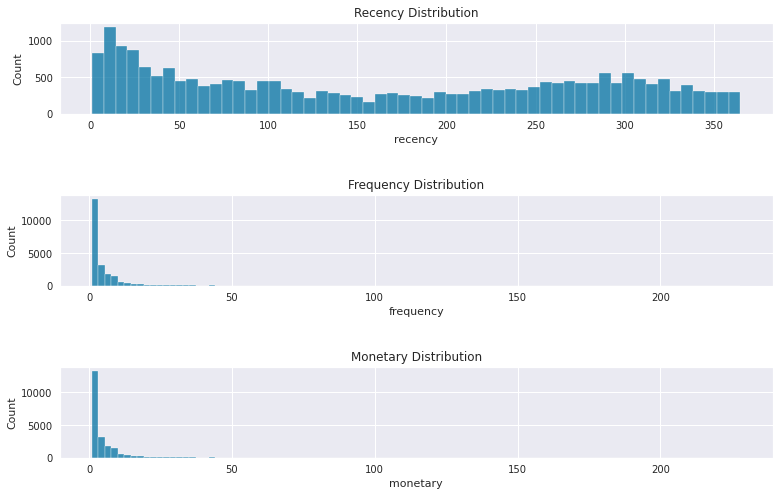

In [9]:
fig,ax = plt.subplots(3,1,figsize = (12,8))
fig.tight_layout(pad=5.0)

sns.histplot(recency.recency,bins = 55,ax=ax[0])
ax[0].set_title("Recency Distribution")

sns.histplot(frequency.frequency,bins = 100,ax=ax[1])
ax[1].set_title("Frequency Distribution")

sns.histplot(monetary.monetary,bins = 100,ax=ax[2])
ax[2].set_title("Monetary Distribution")

From the picture we can see that most of our customers bought our product just recently, they bought infrequently, and spending low amount. 
<br><br>
We can also see that in recency and monetary distribution is right-skewed, and suffering from heavy outliers as the plot below shown. 

<AxesSubplot:ylabel='monetary'>

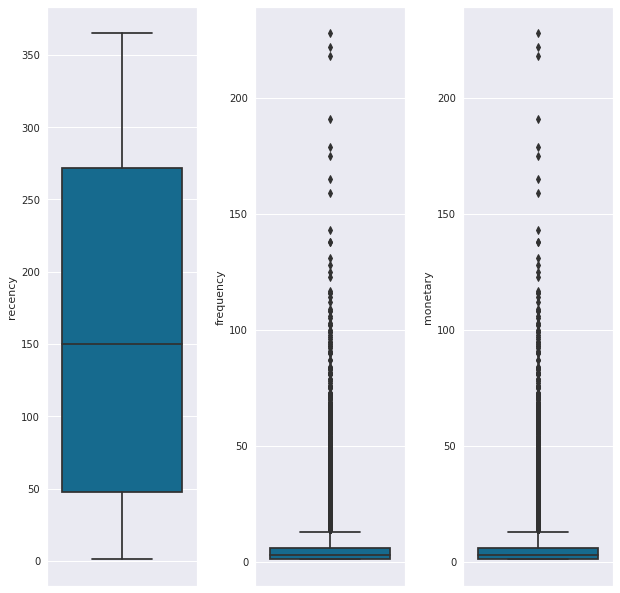

In [10]:
fig,ax = plt.subplots(1,3,figsize = (9,9))
fig.tight_layout(pad=2.0)

sns.boxplot(data=recency, y="recency",ax=ax[0])
sns.boxplot(data=frequency, y="frequency",ax=ax[1])
sns.boxplot(data=monetary, y="monetary",ax=ax[2])

In [11]:
rfm_dataset = pd.concat([recency,frequency,monetary],axis=1)
rfm_dataset = rfm_dataset.iloc[:,[0,3,5,7]]
rfm_dataset.head()

,Customer_ID,recency,frequency,monetary
0,1,345.0,2,2
1,10,324.0,1,1
2,100,364.0,2,2
3,1000,321.0,1,1
4,10000,229.0,3,3


### 4. Finding RFM labels

In [12]:
# Using quartiles
rfm_dataset["recency_score"] = pd.qcut(rfm_dataset['recency'], 5, labels=[5,4,3,2,1])
rfm_dataset["frequency_score"] = pd.qcut(rfm_dataset['frequency'], 5, labels=[1,2,3,4],duplicates='drop')
rfm_dataset["monetary_score"] = pd.qcut(rfm_dataset['monetary'], 5, labels=[1,2,3,4],duplicates='drop')
rfm_dataset["RFM_Score"] = rfm_dataset["recency_score"].astype(str) +rfm_dataset["frequency_score"].astype(str) + rfm_dataset["monetary_score"].astype(str)

In [13]:
rfm_dataset

,Customer_ID,recency,frequency,monetary,recency_score,frequency_score,monetary_score,RFM_Score
0,1,345.0,2,2,1,1,1,111
1,10,324.0,1,1,1,1,1,111
2,100,364.0,2,2,1,1,1,111
3,1000,321.0,1,1,1,1,1,111
4,10000,229.0,3,3,2,2,2,222
...,...,...,...,...,...,...,...,...
22620,9995,11.0,8,8,5,4,4,544
22621,9996,77.0,9,9,4,4,4,444
22622,9997,121.0,1,1,3,1,1,311
22623,9998,172.0,2,2,3,1,1,311


In [14]:
seg_map = {
    r'[1-2][1-2]': 'Hibernating',
    r'[1-2][3-4]': 'At Risk',
    r'[1-2]5': 'Can\'t Loose',
    r'3[1-2]': 'About to Sleep',
    r'33': 'Need Attention',
    r'[3-4][4-5]': 'Loyal Customers',
    r'41': 'Promising',
    r'51': 'New Customers',
    r'[4-5][2-3]': 'Potential Loyalists',
    r'5[4-5]': 'Champions'
}

In [15]:
rfm_dataset['Segment'] = rfm_dataset["recency_score"].astype(str) +rfm_dataset["frequency_score"].astype(str)
rfm_dataset['Segment'] = rfm_dataset['Segment'].replace(seg_map, regex=True)
rfm_dataset.head()

,Customer_ID,recency,frequency,monetary,recency_score,frequency_score,monetary_score,RFM_Score,Segment
0,1,345.0,2,2,1,1,1,111,Hibernating
1,10,324.0,1,1,1,1,1,111,Hibernating
2,100,364.0,2,2,1,1,1,111,Hibernating
3,1000,321.0,1,1,1,1,1,111,Hibernating
4,10000,229.0,3,3,2,2,2,222,Hibernating


In [16]:
rfm_dataset.groupby('Segment').mean().sort_values('monetary')

,recency,frequency,monetary
Segment,,,
Promising,69.099256,1.438213,1.438213
New Customers,18.419023,1.463582,1.463582
Hibernating,289.649219,1.896761,1.896761
About to Sleep,154.944746,2.000604,2.000604
Potential Loyalists,43.991168,4.557409,4.557409
Need Attention,150.386107,5.827141,5.827141
At Risk,283.635800,9.450119,9.450119
Loyal Customers,94.597270,15.208874,15.208874
Champions,15.135422,24.122284,24.122284


### 5. Customer Segmentation
Here we want to see the proportion of each segments in our dataset.

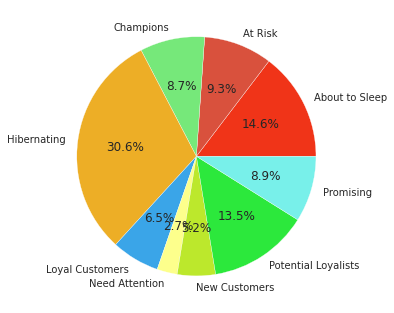

<Figure size 720x720 with 0 Axes>

In [17]:
data = rfm_dataset.groupby("Segment").count()["Customer_ID"]
labels = rfm_dataset.groupby("Segment").count().index
colors = ["#f03418","#d9513d","#76e87a",'#edae26','#3aa5e8',"#fdff8c",
          "#bce82c","#2ce83c","#78f0ea"]
plt.pie(data, labels = labels,autopct='%1.1f%%',colors=colors)
plt.figure(figsize=(10,10))
plt.show()

As we can see, the most customers that we have is in hibernating category (30.6%). Majority of out customers does not lie in the loyal, champions, potential, or promising. This means that we need to activate our customers more. 

In [18]:
rfm_dataset[["Customer_ID","Segment"]]

,Customer_ID,Segment
0,1,Hibernating
1,10,Hibernating
2,100,Hibernating
3,1000,Hibernating
4,10000,Hibernating
...,...,...
22620,9995,Champions
22621,9996,Loyal Customers
22622,9997,About to Sleep
22623,9998,About to Sleep
